# Predykcja cen akcji spółki Microsoft z wykorzystaniem LSTM (ang. Long Short-Term Memory)

## Niezbędne biblioteki

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import *
from keras.api.callbacks import EarlyStopping

## Zbieranie danych
 * Zakres dat: od 01-01-2010 do 01-01-2024
 * Oznaczenie spółki: `MSFT.US`

In [35]:
# Ścieżka do pliku CSV w repozytorium
csv_path = './msft_us_historical_data.csv'

# Sprawdzenie, czy plik istnieje
if not os.path.exists(csv_path):
    # URL do pobrania danych historycznych dla MSFT.US
    url = 'https://stooq.com/q/d/l/?s=msft.us&i=d&d1=20100101&d2=20240101'
    
    # Pobieranie danych
    response = requests.get(url)
    
    # Sprawdzenie, czy żądanie się powiodło
    if response.status_code == 200:
        # Zapisanie danych do pliku CSV w repozytorium
        with open(csv_path, 'wb') as file:
            file.write(response.content)
        
        print(f'Dane zostały pobrane i zapisane do {csv_path}')
    else:
        print(f'Błąd podczas pobierania danych: {response.status_code}')
else:
    print(f'Plik {csv_path} już istnieje')

# Wczytanie danych do DataFrame
df = pd.read_csv(csv_path)

# Wyświetlenie pierwszych kilku wierszy
print(df.head())

# Wyświetlenie podstawowych informacji o danych
print(df.info())

# Zmiana typu kolumny 'Date' na typ daty
df['Date'] = pd.to_datetime(df['Date'])

Plik ./msft_us_historical_data.csv już istnieje
         Date     Open     High      Low    Close        Volume
0  2010-01-04  24.0854  24.4389  24.0358  24.3178  4.886916e+07
1  2010-01-05  24.2542  24.4389  24.0765  24.3267  6.331174e+07
2  2010-01-06  24.2642  24.4230  23.9852  24.1758  7.403254e+07
3  2010-01-07  24.0537  24.1232  23.7221  23.9257  6.434577e+07
4  2010-01-08  23.7837  24.2642  23.7608  24.0934  6.515561e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3522 non-null   object 
 1   Open    3522 non-null   float64
 2   High    3522 non-null   float64
 3   Low     3522 non-null   float64
 4   Close   3522 non-null   float64
 5   Volume  3522 non-null   float64
dtypes: float64(5), object(1)
memory usage: 165.2+ KB
None


## Przygotowanie danych

In [50]:
# Wybór kolumny 'Close' do predykcji
data = df['Close'].values.reshape(-1, 1)

# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tworzenie sekwencji danych
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Podział na zbiór treningowy i testowy
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

y: [[0.01743926]
 [0.01630959]
 [0.01508667]
 ...
 [0.97633151]
 [0.97965004]
 [0.9817344 ]]


## Funkcja do budowy i trenowania modelu

In [43]:
def build_and_train_model(layers=3, neurons=50, optimizer=Adam(), activation='relu', epochs=200, batch_size=32):
    # Tworzenie modelu sekwencyjnego
    model = Sequential()

    # Dodawanie warstw LSTM
    for i in range(layers):
        if i == 0:
            # Pierwsza warstwa LSTM z określonymi neuronami i kształtem wejściowym
            model.add(LSTM(neurons, return_sequences=True, input_shape=(seq_length, 1)))
        elif i == layers - 1:
            # Ostatnia warstwa LSTM bez zwracania sekwencji
            model.add(LSTM(neurons))
        else:
            # Środkowe warstwy LSTM zwracające sekwencje
            model.add(LSTM(neurons, return_sequences=True))
    # Dodawanie warstwy wyjściowej Dense        
    model.add(Dense(1, activation=activation))
    
    # Kompilacja modelu z określonym optymalizatorem i funkcją straty
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Proste wczesne zatrzymanie
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

    # Trenowanie modelu na danych treningowych z walidacją na danych testowych
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, callbacks=[es])
    
    # Zwracanie wytrenowanego modelu i historii trenowania
    return model, history

## Funkcja do rysowania wykresów

In [44]:
def plot_results(df, data, test_data, predicted_data, title, history):
    # Tworzenie wykresu z trzema podwykresami
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15))

    # Wykres podstawowego zbioru danych do momentu prognozowania
    ax1.plot(df['Date'][:split + seq_length], data[:split + seq_length], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji MSFT.US - {title}')
    ax1.legend()
    ax1.grid(True)

    # Wykres przybliżenia okresu testowego i prognoz
    ax2.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length:], predicted_data[split + seq_length:], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    # Wykres błędów trenowania i walidacji
    ax3.plot(history.history['loss'], label='Błąd trenowania')
    ax3.plot(history.history['val_loss'], label='Błąd walidacji')
    ax3.set_xlabel('Epoka')
    ax3.set_ylabel('Błąd')
    ax3.set_title('Błąd trenowania i walidacji')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

## Określenie parametrów do testów

C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Layers: 2, Loss: 0.0006504207849502563
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


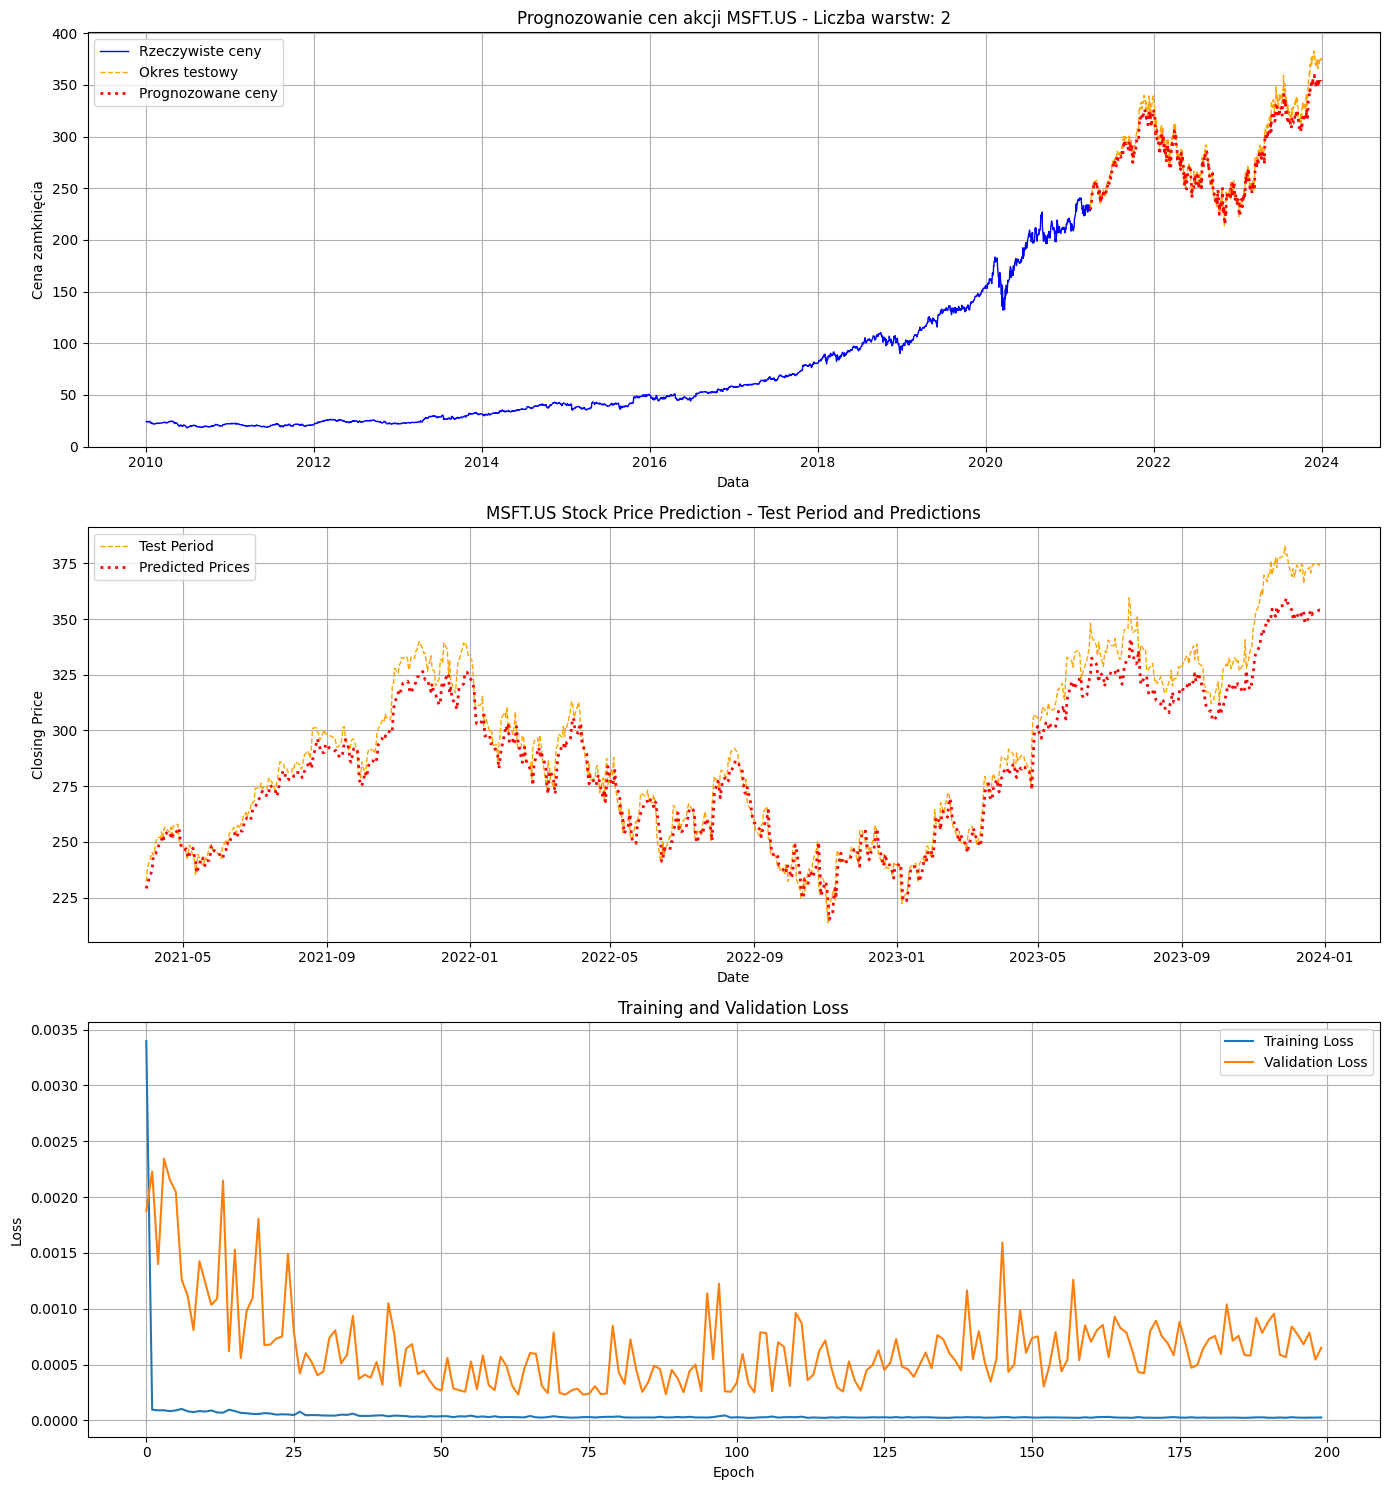

C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Layers: 2, Loss: 0.0005736950552091002
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


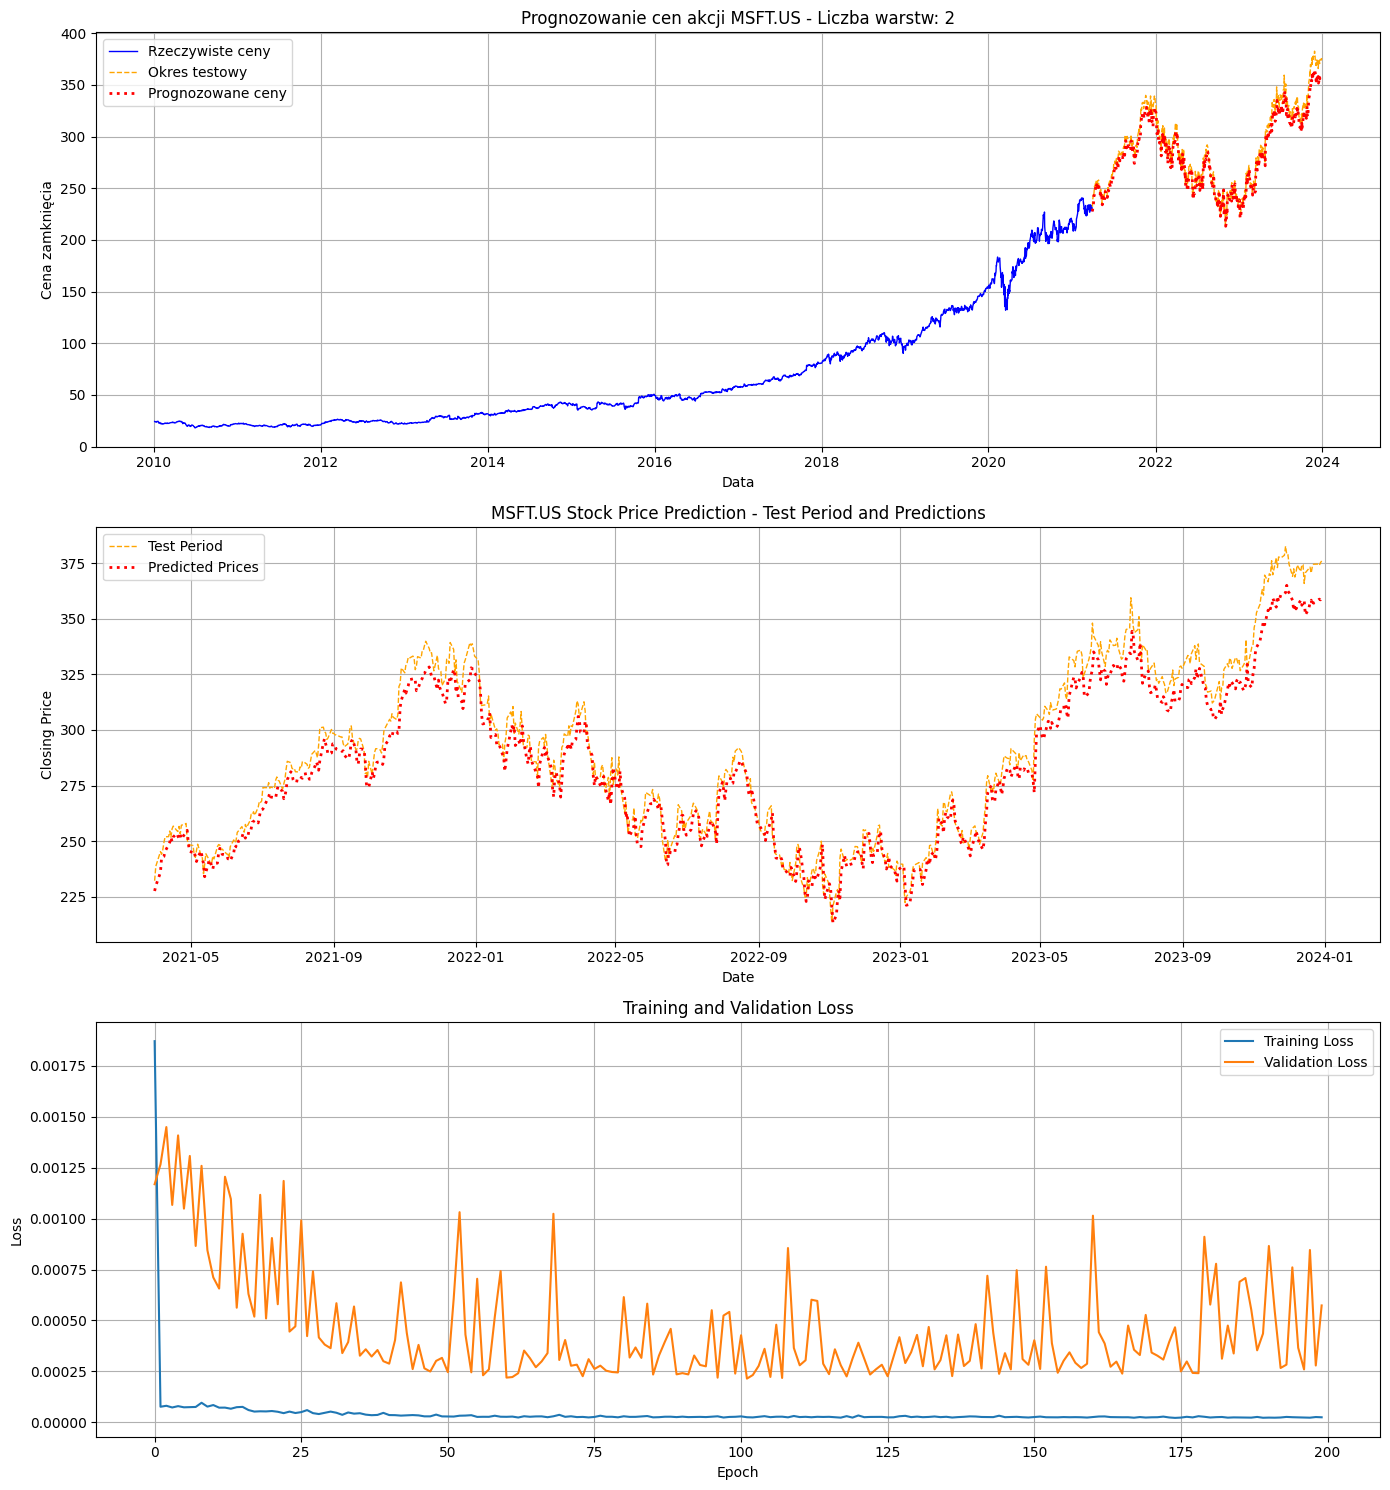

C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Layers: 3, Loss: 0.00040824772440828383
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


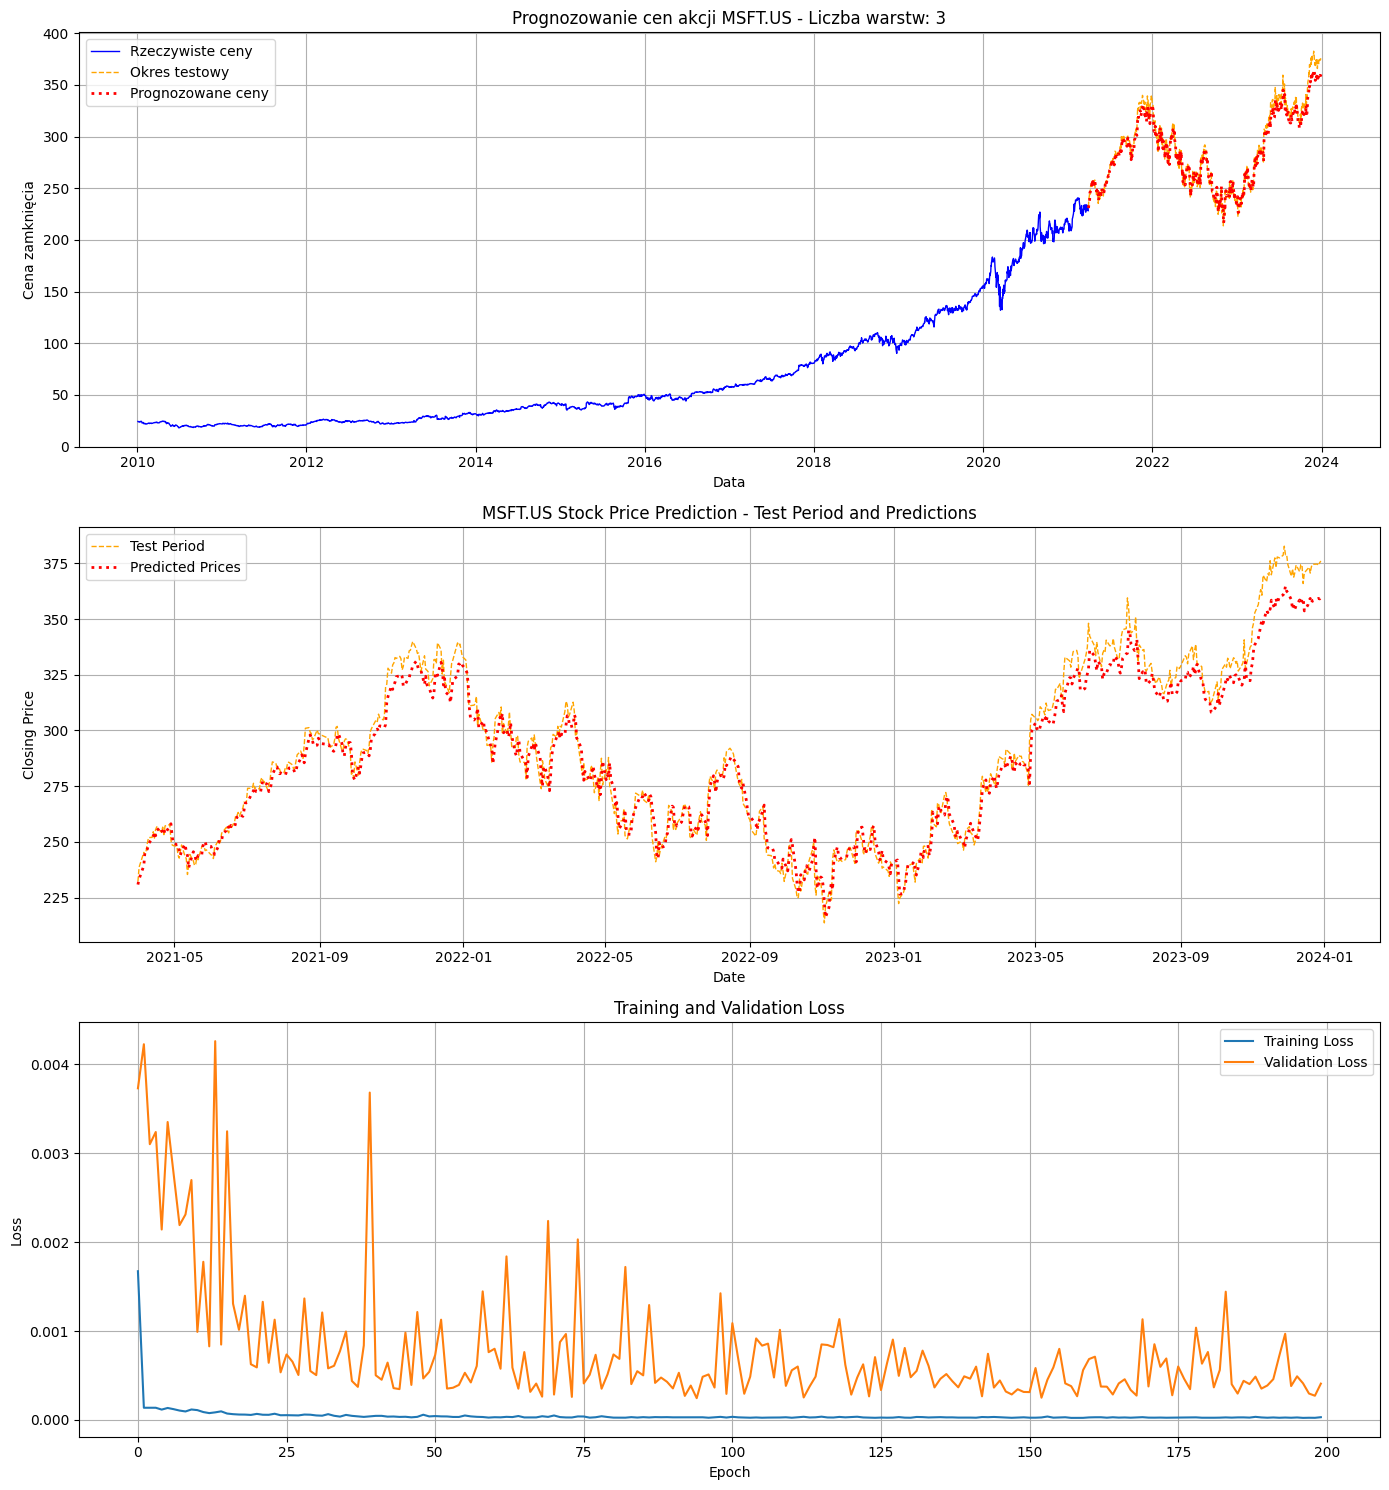

C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Layers: 3, Loss: 0.0006035260739736259
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


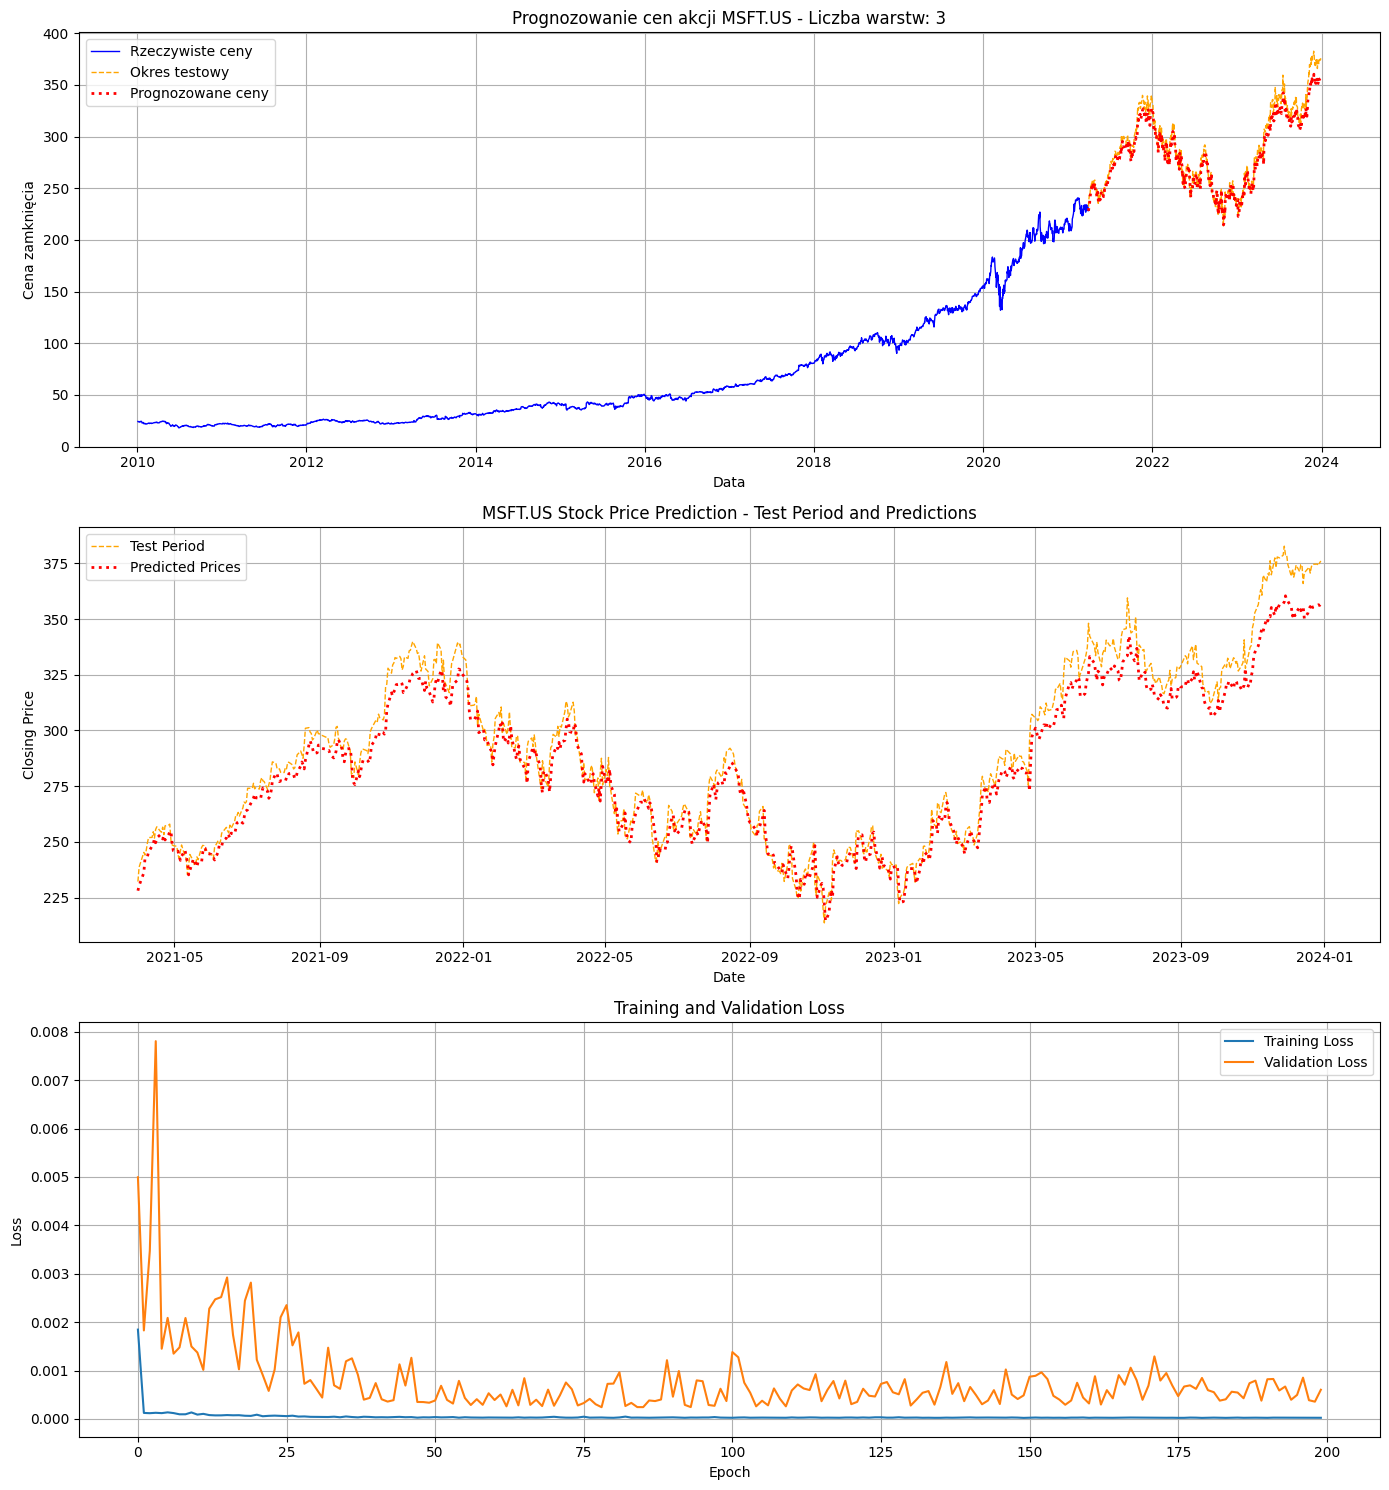

In [45]:
# Parametry do przetestowania
layers_options = [2, 3]
neurons_options = [50, 100, 150, 200]
optimizers_options = [Adam(), RMSprop(), SGD(), Adagrad()]
activations_options = ['relu', 'tanh', 'sigmoid', 'linear']
batch_sizes = [16, 32, 64, 128]


# Przechowywanie wyników
results = []

# Liczba powtórzeń dla każdego zestawu parametrów
num_repeats = 2

# Testowanie wpływu liczby warstw
for layers in layers_options:
    for _ in range(num_repeats):

        model_layers, history_layers = build_and_train_model(layers=layers)
        loss_layers = history_layers.history['val_loss'][-1]
        results.append(('layers', layers, loss_layers))
        print(f'Layers: {layers}, Loss: {loss_layers}')

        # Predykcja na zbiorze testowym
        predicted_layers = model_layers.predict(X_test)
        predicted_layers = scaler.inverse_transform(predicted_layers.reshape(-1, 1))
        
        # Przygotowanie danych do wykresu
        predicted_data_layers = np.empty_like(data)
        predicted_data_layers[:, :] = np.nan
        predicted_data_layers[split + seq_length:] = predicted_layers
        
        # Rysowanie wykresu
        plot_results(df, data, data[split + seq_length:], predicted_data_layers, f'Liczba warstw: {layers}', history_layers)


In [ ]:
# Testowanie wpływu liczby neuronów
for neurons in neurons_options:
    for _ in range(num_repeats):
        model_neurons, history_neurons = build_and_train_model(neurons=neurons)
        loss_neurons = history_neurons.history['val_loss'][-1]
        results.append(('neurons', neurons, loss_neurons))
        print(f'Neurons: {neurons}, Loss: {loss_neurons}')
        
        # Predykcja na zbiorze testowym
        predicted_neurons = model_neurons.predict(X_test)
        predicted_neurons = scaler.inverse_transform(predicted_neurons)
        
        # Przygotowanie danych do wykresu
        predicted_data_neurons = np.empty_like(data)
        predicted_data_neurons[:, :] = np.nan
        predicted_data_neurons[split + seq_length:] = predicted_neurons
        
        # Rysowanie wykresu
        plot_results(df, data, test_data, predicted_data_neurons, f'Liczba neuronów: {neurons}', history_neurons)

In [ ]:
# Testowanie wpływu optymalizatora
for optimizer in optimizers_options:
    for _ in range(num_repeats):
        model_optimizer, history_optimizer = build_and_train_model(optimizer=optimizer)
        loss_optimizer = history_optimizer.history['val_loss'][-1]
        results.append(('optimizer', optimizer.__class__.__name__, loss_optimizer))
        print(f'Optimizer: {optimizer.__class__.__name__}, Loss: {loss_optimizer}')
        
        # Predykcja na zbiorze testowym
        predicted_optimizer = model_optimizer.predict(X_test)
        predicted_optimizer = scaler.inverse_transform(predicted_optimizer)
        
        # Przygotowanie danych do wykresu
        predicted_data_optimizer = np.empty_like(data)
        predicted_data_optimizer[:, :] = np.nan
        predicted_data_optimizer[split + seq_length:] = predicted_optimizer
        
        # Rysowanie wykresu
        plot_results(df, data, test_data, predicted_data_optimizer, f'Optymalizator: {optimizer.__class__.__name__}', history_optimizer)

In [ ]:
# Testowanie wpływu funkcji aktywacji
for activation in activations_options:
    for _ in range(num_repeats):
        model_activation, history_activation = build_and_train_model(activation=activation)
        loss_activation = history_activation.history['val_loss'][-1]
        results.append(('activation', activation, loss_activation))
        print(f'Activation: {activation}, Loss: {loss_activation}')
        
        # Predykcja na zbiorze testowym
        predicted_activation = model_activation.predict(X_test)
        predicted_activation = scaler.inverse_transform(predicted_activation)
        
        # Przygotowanie danych do wykresu
        predicted_data_activation = np.empty_like(data)
        predicted_data_activation[:, :] = np.nan
        predicted_data_activation[split + seq_length:] = predicted_activation
        
        # Rysowanie wykresu
        plot_results(df, data, test_data, predicted_data_activation, f'Funkcja aktywacji: {activation}', history_activation)

In [ ]:
# Testowanie wpływu wielkości batch size
for batch_size in batch_sizes:
    for _ in range(num_repeats):
        model_batch_size, history_batch_size = build_and_train_model(batch_size=batch_size)
        loss_batch_size = history_batch_size.history['val_loss'][-1]
        results.append(('batch_size', batch_size, loss_batch_size))
        print(f'Batch size: {batch_size}, Loss: {loss_batch_size}')

        # Predykcja na zbiorze testowym
        predicted_batch_size = model_batch_size.predict(X_test)
        predicted_batch_size = scaler.inverse_transform(predicted_batch_size)

        # Przygotowanie danych do wykresu
        predicted_data_batch_size = np.empty_like(data)
        predicted_data_batch_size[:, :] = np.nan
        predicted_data_batch_size[split + seq_length:] = predicted_batch_size

        # Rysowanie wykresu
        plot_results(df, data, test_data, predicted_data_batch_size, f'Batch size: {batch_size}', history_batch_size)